In [2]:
from data_loading import *
import matplotlib.pyplot as plt

c:\Users\samar\Desktop\Samar\Studies\MSc\BiBC\AIMI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\samar\Desktop\Samar\Studies\MSc\BiBC\AIMI\venv\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [13]:
def load_nifti_image(image_path: Path):
    """Load a NIfTI image using SimpleITK."""
    image = sitk.ReadImage(str(image_path))
    return sitk.GetArrayFromImage(image)  # Convert to NumPy array

In [78]:
subject_dir = Path("./data/WMH/Utrecht/0/")

flair_path = subject_dir / "FLAIR.nii.gz"
t1_path = subject_dir / "T1.nii.gz"
WMH_path = subject_dir / "wmh.nii.gz"

sample = {
    "flair": flair_path,
    "t1": t1_path,
    "WMH": WMH_path
}

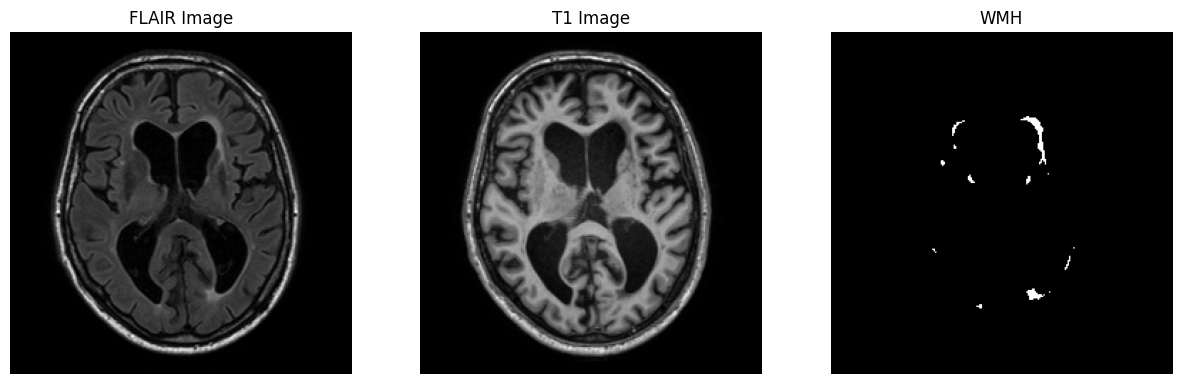

In [15]:
def visualize_sample(sample):
    """Visualize FLAIR, T1, and WMH images from a sample."""
    flair_image = sample['flair']
    t1_image = sample['t1']
    label_image = sample['WMH']

    # Select a slice to visualize (e.g., the middle slice)
    slice_index = flair_image.shape[0] // 2

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # FLAIR Image
    axes[0].imshow(flair_image[slice_index, :, :], cmap='gray')
    axes[0].set_title('FLAIR Image')
    axes[0].axis('off')

    # T1 Image
    axes[1].imshow(t1_image[slice_index, :, :], cmap='gray')
    axes[1].set_title('T1 Image')
    axes[1].axis('off')

    # WMH Label
    axes[2].imshow(label_image[slice_index, :, :], cmap='gray')
    axes[2].set_title('WMH')
    axes[2].axis('off')

    plt.show()


visualize_sample(sample)

In [71]:
# Define each transform separately
transforms = {
    "Load Image": LoadImaged(keys=["flair", "t1", "WMH"]),
    "Ensure Channel First": EnsureChannelFirstd(keys=["flair", "t1", "WMH"]),
    "Random Spatial Crop": RandSpatialCropd(keys=["flair", "t1", "WMH"], roi_size=(32, 32, 32)),
    "Random Flip": RandFlipd(keys=["flair", "t1", "WMH"], prob=0.5, spatial_axis=0),
    "Random Rotate": RandRotated(
        keys=["flair", "t1", "WMH"],
        range_x=(-30, 30),
        range_y=(-30, 30),
        range_z=(-30, 30),
        prob=1.0,
        mode=("bilinear", "bilinear", "nearest"),
        align_corners=True
    ),
    "Random Affine": RandAffined(
        keys=["flair", "t1", "WMH"],
        prob=1.0,
        rotate_range=(0, 30),
        shear_range=(0.05, 0.1),
        scale_range=(0.9, 1.1)
    ),
    "Normalize Intensity": NormalizeIntensityd(keys=["flair", "t1"])
}

In [79]:
# Helper function to visualize a transform
def visualize_transform(transform, data, title, index):
    transformed_data = transform(data)
    flair = data["flair"]
    flair_trans = transformed_data["flair"]
    
    plt.subplot(1, len(transforms), index)
    plt.imshow(flair_trans[flair_trans.shape[0] // 2, :, :], cmap="gray")
    plt.title(title)
    plt.axis("off")

# Visualize each transform step by step
plt.figure(figsize=(20, 5))
data = sample.copy()
image = transforms["Normalize Intensity"](transforms["Ensure Channel First"](transforms["Load Image"](data)))
for idx, (name, transform) in enumerate(transforms.items(), start=1):
    print(idx, name)
    visualize_transform(Compose([transform]), image, name, idx)
plt.show()

1 Load Image


RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x000001AD67E65280>

<Figure size 2000x500 with 0 Axes>

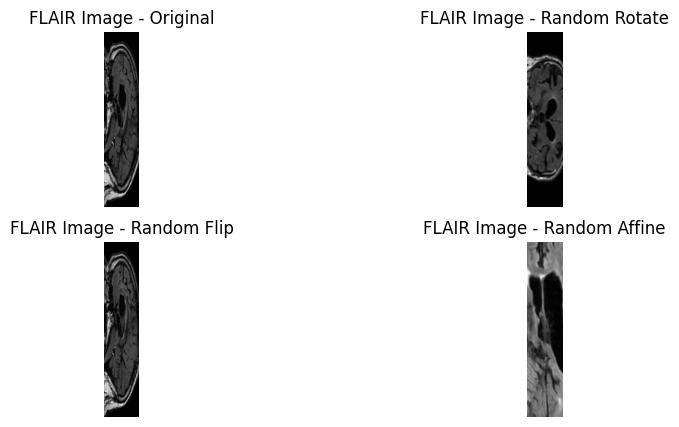

In [91]:
# transform = RandFlipd(keys=["flair", "t1", "WMH"], prob=0.5, spatial_axis=0)
data = sample.copy()
image = transforms["Normalize Intensity"](transforms["Ensure Channel First"](transforms["Load Image"](data)))

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

image_crop = transforms["Random Spatial Crop"](image)["flair"].squeeze(0)
image_flip = transforms["Random Flip"](image)["flair"].squeeze(0)
image_rotate = transforms["Random Rotate"](image)["flair"].squeeze(0)
image_affine = transforms["Random Affine"](image)["flair"].squeeze(0)

# original
axes[0,0].imshow(image["flair"].squeeze(0)[image["flair"].squeeze(0).shape[0] // 2, :, :], cmap='gray')
axes[0,0].set_title('FLAIR Image - Original')
axes[0,0].axis('off')
# axes[0,0].imshow(image_crop[image_crop.shape[0] // 2, :, :], cmap='gray')
# axes[0,0].set_title('FLAIR Image - Random Spatial Crop')
# axes[0,0].axis('off')
# rotate
axes[0,1].imshow(image_rotate[image_rotate.shape[0] // 2, :, :], cmap='gray')
axes[0,1].set_title(f'FLAIR Image - Random Rotate')
axes[0,1].axis('off')
# flip
axes[1,0].imshow(image_flip[image_flip.shape[0] // 2, :, :], cmap='gray')
axes[1,0].set_title(f'FLAIR Image - Random Flip')
axes[1,0].axis('off')
# rotate
axes[1,1].imshow(image_affine[image_affine.shape[0] // 2, :, :], cmap='gray')
axes[1,1].set_title(f'FLAIR Image - Random Affine')
axes[1,1].axis('off')

plt.show()

In [77]:
image = transforms["Normalize Intensity"](transforms["Ensure Channel First"](transforms["Load Image"](sample)))

print(image["flair"].shape, image["t1"].shape, image["WMH"].shape)
trans_image = transforms["Random Spatial Crop"](image)["flair"]


torch.Size([1, 240, 240, 48]) torch.Size([1, 240, 240, 48]) torch.Size([1, 240, 240, 48])


metatensor([[[[ 3.7646e-01,  6.9065e-01,  1.0660e+00,  ...,  7.7093e-01,
            6.6369e-01,  7.7464e-01],
          [ 3.1246e-01,  8.2919e-01,  8.4206e-01,  ...,  7.4443e-01,
            7.1836e-01,  7.1031e-01],
          [ 2.2288e-01,  9.1291e-01,  7.5773e-01,  ...,  6.7017e-01,
            7.1206e-01,  8.3023e-01],
          ...,
          [ 3.8404e+00,  1.9292e+00,  3.5347e+00,  ...,  6.5160e-01,
            6.9986e-02,  7.6263e-01],
          [ 4.3305e+00,  3.8271e+00,  4.0557e+00,  ...,  3.9897e-01,
           -3.4071e-01, -1.3843e-02],
          [ 4.2543e+00,  4.4238e+00,  3.5353e+00,  ..., -2.3378e-02,
           -2.9748e-01, -1.9805e-01]],

         [[ 2.5205e-01,  8.4445e-01,  8.5726e-01,  ...,  8.0188e-01,
            6.5684e-01,  6.7936e-01],
          [ 2.4255e-02,  9.1888e-01,  9.2273e-01,  ...,  7.9919e-01,
            7.1158e-01,  7.9214e-01],
          [-1.6825e-01,  8.3481e-01,  9.8815e-01,  ...,  7.2485e-01,
            8.1119e-01,  9.0223e-01],
          ...,
 

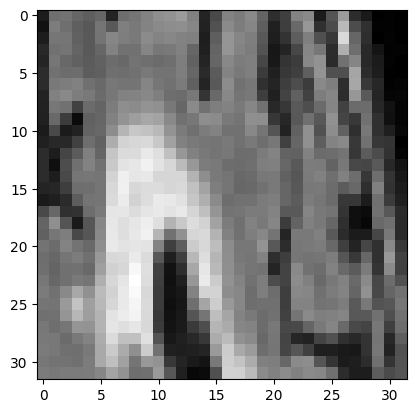

In [ ]:
image_crop_2 = transforms["Random Spatial Crop"](image)["flair"].squeeze(0)
plt.imshow(image_crop_2[image_crop_2.shape[0] // 2, :, :], cmap='gray')
plt.title(f"FLAIR Image - Random Spatial Crop")
plt.axis("off")